## 📦 Part 1: Setup and Installation

Installing all required libraries for the multi-task learning framework.

In [1]:
# Install required packages
!pip install -q transformers>=4.30.0
!pip install -q datasets
!pip install -q scikit-learn
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q tqdm
!pip install -q accelerate
!pip install -q sentencepiece  # For XLM-RoBERTa
!pip install -q protobuf

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


## 📚 Part 2: Import Libraries

In [2]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Optional, Set, Union
from dataclasses import dataclass, field
from collections import defaultdict, Counter
import re
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    get_linear_schedule_with_warmup,
    set_seed
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    precision_recall_fscore_support,
    classification_report
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Set random seeds for reproducibility
SEED = 42
set_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")
print(f"🎲 Random seed: {SEED}")

if torch.cuda.is_available():
    print(f"💻 GPU: {torch.cuda.get_device_name(0)}")
    print(f"📊 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ Running on CPU - training will be slower")

🚀 Device: cuda
🎲 Random seed: 42
💻 GPU: Tesla T4
📊 Memory: 15.83 GB


## ⚙️ Part 3: Configuration

Comprehensive configuration for both Subtask 2 and 3.

In [3]:
@dataclass
class Config:
    """
    Comprehensive configuration for DimABSA Subtask 2 & 3.

    Supports multi-task learning with:
    - Aspect/Opinion extraction (BIO tagging)
    - Category classification (multi-label)
    - VA regression (dual-head)
    """

    # ==================== Task Configuration ====================
    subtask: int = 3  # 2 for DimASTE, 3 for DimASQP
    track: str = "track_a"
    language: str = "eng"  # Options: eng, jpn, rus, tat, ukr, zho
    domain: str = "restaurant"  # Options: restaurant, laptop, hotel, finance

    # ==================== Model Configuration ====================
    model_name: str = "bert-base-multilingual-cased"
    # Alternative models to consider:
    # - "xlm-roberta-base" (better multilingual)
    # - "xlm-roberta-large" (best performance, more GPU)
    # - "microsoft/mdeberta-v3-base" (state-of-the-art)
    # - "bert-base-uncased" (English only)

    # ==================== Training Hyperparameters ====================
    max_length: int = 256  # Increased for longer sequences
    batch_size: int = 8  # Smaller due to multi-task complexity
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    num_epochs: int = 10
    warmup_ratio: float = 0.1
    gradient_clip: float = 1.0

    # ==================== Data Split ====================
    val_split: float = 0.15

    # ==================== Output Configuration ====================
    output_dir: str = "./outputs_task23"
    save_best_model: bool = True
    save_predictions: bool = True

    # ==================== Advanced Settings ====================
    dropout_rate: float = 0.2
    use_crf: bool = False  # Use CRF for sequence tagging (optional)
    use_scheduler: bool = True
    scheduler_type: str = "linear"  # Options: linear, cosine, plateau

    # ==================== Multi-Task Loss Weights ====================
    loss_weight_aspect: float = 1.0      # Weight for aspect tagging loss
    loss_weight_opinion: float = 1.0     # Weight for opinion tagging loss
    loss_weight_category: float = 1.0    # Weight for category classification loss
    loss_weight_valence: float = 1.0     # Weight for valence regression loss
    loss_weight_arousal: float = 1.0     # Weight for arousal regression loss

    # ==================== VA Score Constraints ====================
    va_min: float = 1.0
    va_max: float = 9.0

    # ==================== BIO Tagging Configuration ====================
    aspect_labels: List[str] = field(default_factory=lambda: ['O', 'B-ASP', 'I-ASP'])
    opinion_labels: List[str] = field(default_factory=lambda: ['O', 'B-OPN', 'I-OPN'])

    # ==================== Category Labels (Domain-Specific) ====================
    # Will be populated in __post_init__ based on domain
    category_labels: List[str] = field(default_factory=list)

    def __post_init__(self):
        """Initialize derived configurations"""
        # Create output directory
        os.makedirs(self.output_dir, exist_ok=True)

        # Build data URLs
        base_url = "https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset"
        subtask_str = f"subtask_{self.subtask}"
        task_str = f"task{self.subtask}"

        self.train_url = (
            f"{base_url}/{self.track}/{subtask_str}/{self.language}/"
            f"{self.language}_{self.domain}_train_alltasks.jsonl"
        )
        self.dev_url = (
            f"{base_url}/{self.track}/{subtask_str}/{self.language}/"
            f"{self.language}_{self.domain}_dev_{task_str}.jsonl"
        )

        # Set domain-specific category labels
        self._init_category_labels()

        # Label to index mappings
        self.aspect_label2id = {label: idx for idx, label in enumerate(self.aspect_labels)}
        self.aspect_id2label = {idx: label for label, idx in self.aspect_label2id.items()}

        self.opinion_label2id = {label: idx for idx, label in enumerate(self.opinion_labels)}
        self.opinion_id2label = {idx: label for label, idx in self.opinion_label2id.items()}

        if self.subtask == 3:
            self.category_label2id = {label: idx for idx, label in enumerate(self.category_labels)}
            self.category_id2label = {idx: label for label, idx in self.category_label2id.items()}

    def _init_category_labels(self):
        """Initialize domain-specific category labels"""
        if self.domain == "restaurant":
            entities = ['RESTAURANT', 'FOOD', 'DRINKS', 'AMBIENCE', 'SERVICE', 'LOCATION']
            attributes = ['GENERAL', 'PRICES', 'QUALITY', 'STYLE_OPTIONS', 'MISCELLANEOUS']
        elif self.domain == "laptop":
            entities = [
                'LAPTOP', 'DISPLAY', 'KEYBOARD', 'MOUSE', 'MOTHERBOARD', 'CPU',
                'FANS_COOLING', 'PORTS', 'MEMORY', 'POWER_SUPPLY', 'OPTICAL_DRIVES',
                'BATTERY', 'GRAPHICS', 'HARD_DISK', 'MULTIMEDIA_DEVICES', 'HARDWARE',
                'SOFTWARE', 'OS', 'WARRANTY', 'SHIPPING', 'SUPPORT', 'COMPANY'
            ]
            attributes = [
                'GENERAL', 'PRICE', 'QUALITY', 'DESIGN_FEATURES', 'OPERATION_PERFORMANCE',
                'USABILITY', 'PORTABILITY', 'CONNECTIVITY', 'MISCELLANEOUS'
            ]
        elif self.domain == "hotel":
            entities = ['HOTEL', 'ROOMS', 'FACILITIES', 'ROOM_AMENITIES', 'SERVICE', 'LOCATION', 'FOOD_DRINKS']
            attributes = [
                'GENERAL', 'PRICE', 'COMFORT', 'CLEANLINESS', 'QUALITY',
                'DESIGN_FEATURES', 'STYLE_OPTIONS', 'MISCELLANEOUS'
            ]
        elif self.domain == "finance":
            # Finance domain categories (based on common patterns)
            entities = ['COMPANY', 'PRODUCT', 'SERVICE', 'MARKET', 'PERFORMANCE']
            attributes = ['GENERAL', 'QUALITY', 'TREND', 'RISK', 'MISCELLANEOUS']
        else:
            raise ValueError(f"Unknown domain: {self.domain}")

        # Create all valid ENTITY#ATTRIBUTE combinations
        self.category_labels = [f"{e}#{a}" for e in entities for a in attributes]
        # Add special NULL category for implicit aspects
        self.category_labels.insert(0, "NULL")

    def display(self):
        """Display configuration in a readable format"""
        print("=" * 80)
        print("🔧 CONFIGURATION - DimABSA Subtask 2 & 3")
        print("=" * 80)

        print("\n📋 Task Settings:")
        print(f"  Subtask:           {self.subtask} ({'DimASTE (Triplet)' if self.subtask == 2 else 'DimASQP (Quadruplet)'})")
        print(f"  Language:          {self.language}")
        print(f"  Domain:            {self.domain}")

        print("\n🧠 Model Settings:")
        print(f"  Model:             {self.model_name}")
        print(f"  Max Length:        {self.max_length}")
        print(f"  Dropout:           {self.dropout_rate}")
        print(f"  Use CRF:           {self.use_crf}")

        print("\n🎯 Training Settings:")
        print(f"  Batch Size:        {self.batch_size}")
        print(f"  Learning Rate:     {self.learning_rate}")
        print(f"  Epochs:            {self.num_epochs}")
        print(f"  Warmup Ratio:      {self.warmup_ratio}")
        print(f"  Weight Decay:      {self.weight_decay}")
        print(f"  Gradient Clip:     {self.gradient_clip}")

        print("\n⚖️ Multi-Task Loss Weights:")
        print(f"  Aspect Tagging:    {self.loss_weight_aspect}")
        print(f"  Opinion Tagging:   {self.loss_weight_opinion}")
        if self.subtask == 3:
            print(f"  Category Class:    {self.loss_weight_category}")
        print(f"  Valence Regress:   {self.loss_weight_valence}")
        print(f"  Arousal Regress:   {self.loss_weight_arousal}")

        print("\n🏷️ Label Information:")
        print(f"  Aspect Labels:     {len(self.aspect_labels)} ({', '.join(self.aspect_labels)})")
        print(f"  Opinion Labels:    {len(self.opinion_labels)} ({', '.join(self.opinion_labels)})")
        if self.subtask == 3:
            print(f"  Category Labels:   {len(self.category_labels)} categories")
            print(f"    Sample:          {', '.join(self.category_labels[:5])}...")

        print("\n📁 Paths:")
        print(f"  Output Dir:        {self.output_dir}")

        print("=" * 80)

# Initialize configuration
config = Config(
    subtask=3,  # Change to 2 for Subtask 2
    language="eng",
    domain="restaurant"
)
config.display()

🔧 CONFIGURATION - DimABSA Subtask 2 & 3

📋 Task Settings:
  Subtask:           3 (DimASQP (Quadruplet))
  Language:          eng
  Domain:            restaurant

🧠 Model Settings:
  Model:             bert-base-multilingual-cased
  Max Length:        256
  Dropout:           0.2
  Use CRF:           False

🎯 Training Settings:
  Batch Size:        8
  Learning Rate:     2e-05
  Epochs:            10
  Warmup Ratio:      0.1
  Weight Decay:      0.01
  Gradient Clip:     1.0

⚖️ Multi-Task Loss Weights:
  Aspect Tagging:    1.0
  Opinion Tagging:   1.0
  Category Class:    1.0
  Valence Regress:   1.0
  Arousal Regress:   1.0

🏷️ Label Information:
  Aspect Labels:     3 (O, B-ASP, I-ASP)
  Opinion Labels:    3 (O, B-OPN, I-OPN)
  Category Labels:   31 categories
    Sample:          NULL, RESTAURANT#GENERAL, RESTAURANT#PRICES, RESTAURANT#QUALITY, RESTAURANT#STYLE_OPTIONS...

📁 Paths:
  Output Dir:        ./outputs_task23


## 📊 Part 4: Data Loading and Processing

Load and process JSONL data with support for both Triplets (Task 2) and Quadruplets (Task 3).

In [4]:
def load_jsonl_from_url(url: str) -> List[Dict]:
    """
    Load JSONL data from URL.

    Args:
        url: URL to JSONL file

    Returns:
        List of dictionaries
    """
    import urllib.request

    try:
        with urllib.request.urlopen(url) as response:
            data = response.read().decode('utf-8')
            return [json.loads(line) for line in data.strip().split('\n') if line.strip()]
    except Exception as e:
        print(f"❌ Error loading data from {url}: {e}")
        raise


def parse_quadruplet_data(data: List[Dict]) -> pd.DataFrame:
    """
    Parse quadruplet format data into DataFrame.

    Input format:
    {
        "ID": "rest16_quad_dev_1",
        "Text": "the food was amazing",
        "Quadruplet": [
            {
                "Aspect": "food",
                "Category": "FOOD#QUALITY",
                "Opinion": "amazing",
                "VA": "8.5#7.2"
            }
        ]
    }

    Returns:
        DataFrame with one row per sample (quadruplets stored as list)
    """
    samples = []

    for item in data:
        sample_id = item['ID']
        text = item['Text']
        quads = item.get('Quadruplet', [])

        # Store quadruplets as structured data
        quadruplets = []
        for quad in quads:
            aspect = quad.get('Aspect', 'NULL')
            category = quad.get('Category', 'NULL')
            opinion = quad.get('Opinion', 'NULL')
            va_str = quad.get('VA', '5.0#5.0')

            # Parse VA
            try:
                valence, arousal = map(float, va_str.split('#'))
            except:
                valence, arousal = 5.0, 5.0

            quadruplets.append({
                'aspect': aspect,
                'category': category,
                'opinion': opinion,
                'valence': valence,
                'arousal': arousal
            })

        samples.append({
            'ID': sample_id,
            'Text': text,
            'Quadruplets': quadruplets,
            'num_quads': len(quadruplets)
        })

    return pd.DataFrame(samples)


def parse_triplet_data(data: List[Dict]) -> pd.DataFrame:
    """
    Parse triplet format data into DataFrame.

    Similar to quadruplet but without Category field.
    """
    samples = []

    for item in data:
        sample_id = item['ID']
        text = item['Text']

        # Handle both 'Triplet' and 'Quadruplet' keys (training data has Quadruplet)
        trips = item.get('Triplet', item.get('Quadruplet', []))

        triplets = []
        for trip in trips:
            aspect = trip.get('Aspect', 'NULL')
            opinion = trip.get('Opinion', 'NULL')
            va_str = trip.get('VA', '5.0#5.0')

            try:
                valence, arousal = map(float, va_str.split('#'))
            except:
                valence, arousal = 5.0, 5.0

            triplets.append({
                'aspect': aspect,
                'opinion': opinion,
                'valence': valence,
                'arousal': arousal
            })

        samples.append({
            'ID': sample_id,
            'Text': text,
            'Triplets': triplets,
            'num_trips': len(triplets)
        })

    return pd.DataFrame(samples)


def load_and_split_data(
    config: Config
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load and split data into train/val/test sets.

    Args:
        config: Configuration object

    Returns:
        train_df, val_df, test_df
    """
    print("\n" + "=" * 80)
    print("📥 LOADING DATA")
    print("=" * 80)

    # Load training data
    print(f"\n📂 Loading training data...")
    print(f"   URL: {config.train_url}")
    train_raw = load_jsonl_from_url(config.train_url)

    # Parse based on subtask
    if config.subtask == 3:
        train_df = parse_quadruplet_data(train_raw)
    else:
        train_df = parse_triplet_data(train_raw)

    print(f"   ✅ Loaded {len(train_df)} training samples")

    # Load test data (dev set)
    print(f"\n📂 Loading test data...")
    print(f"   URL: {config.dev_url}")
    test_raw = load_jsonl_from_url(config.dev_url)

    # Test data format (no labels)
    test_samples = []
    for item in test_raw:
        test_samples.append({
            'ID': item['ID'],
            'Text': item['Text'],
            'Quadruplets' if config.subtask == 3 else 'Triplets': [],  # Empty for test
            f'num_{"quads" if config.subtask == 3 else "trips"}': 0
        })
    test_df = pd.DataFrame(test_samples)
    print(f"   ✅ Loaded {len(test_df)} test samples")

    # Split training into train/val
    print(f"\n✂️ Splitting training data (val_split={config.val_split})...")
    train_df, val_df = train_test_split(
        train_df,
        test_size=config.val_split,
        random_state=SEED,
        shuffle=True
    )

    # Reset indices
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print("\n" + "=" * 80)
    print("📊 DATA SPLIT SUMMARY")
    print("=" * 80)
    print(f"  Train:  {len(train_df):,} samples")
    print(f"  Val:    {len(val_df):,} samples")
    print(f"  Test:   {len(test_df):,} samples")
    print(f"  Total:  {len(train_df) + len(val_df) + len(test_df):,} samples")
    print("=" * 80)

    return train_df, val_df, test_df


# Load data
train_df, val_df, test_df = load_and_split_data(config)


📥 LOADING DATA

📂 Loading training data...
   URL: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_3/eng/eng_restaurant_train_alltasks.jsonl
   ✅ Loaded 2284 training samples

📂 Loading test data...
   URL: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_3/eng/eng_restaurant_dev_task3.jsonl
   ✅ Loaded 200 test samples

✂️ Splitting training data (val_split=0.15)...

📊 DATA SPLIT SUMMARY
  Train:  1,941 samples
  Val:    343 samples
  Test:   200 samples
  Total:  2,484 samples


## 🔍 Part 5: Exploratory Data Analysis (EDA)

Comprehensive analysis of the data distribution, quadruplet/triplet patterns, and VA scores.

In [5]:
def analyze_dataset(df: pd.DataFrame, config: Config, dataset_name: str = "Dataset"):
    """
    Perform comprehensive EDA on the dataset.

    Args:
        df: DataFrame to analyze
        config: Configuration object
        dataset_name: Name for display
    """
    print("\n" + "=" * 80)
    print(f"📊 EDA: {dataset_name}")
    print("=" * 80)

    # Basic info
    print(f"\n📋 Basic Information:")
    print(f"  Total samples: {len(df):,}")
    print(f"  Columns: {df.columns.tolist()}")

    # Text statistics
    df['text_length'] = df['Text'].str.len()
    df['word_count'] = df['Text'].str.split().str.len()

    print(f"\n📏 Text Statistics:")
    print(f"  Avg text length: {df['text_length'].mean():.1f} chars (std: {df['text_length'].std():.1f})")
    print(f"  Avg word count:  {df['word_count'].mean():.1f} words (std: {df['word_count'].std():.1f})")
    print(f"  Min/Max length:  {df['text_length'].min()} / {df['text_length'].max()} chars")
    print(f"  Min/Max words:   {df['word_count'].min()} / {df['word_count'].max()} words")

    # Quadruplet/Triplet analysis (if available)
    entity_col = 'Quadruplets' if config.subtask == 3 else 'Triplets'
    count_col = 'num_quads' if config.subtask == 3 else 'num_trips'

    if count_col in df.columns and df[count_col].sum() > 0:
        entity_name = "quadruplets" if config.subtask == 3 else "triplets"

        print(f"\n🎯 {entity_name.capitalize()} Statistics:")
        print(f"  Total {entity_name}: {df[count_col].sum():,}")
        print(f"  Avg per sample: {df[count_col].mean():.2f}")
        print(f"  Samples with 0: {(df[count_col] == 0).sum():,}")
        print(f"  Samples with 1: {(df[count_col] == 1).sum():,}")
        print(f"  Samples with 2+: {(df[count_col] >= 2).sum():,}")
        print(f"  Max {entity_name}/sample: {df[count_col].max()}")

        # Extract all entities
        all_entities = []
        all_aspects = []
        all_opinions = []
        all_categories = [] if config.subtask == 3 else None
        all_valences = []
        all_arousals = []

        for entities_list in df[entity_col]:
            if isinstance(entities_list, list):
                for entity in entities_list:
                    all_entities.append(entity)
                    all_aspects.append(entity.get('aspect', 'NULL'))
                    all_opinions.append(entity.get('opinion', 'NULL'))
                    if config.subtask == 3:
                        all_categories.append(entity.get('category', 'NULL'))
                    all_valences.append(entity.get('valence', 5.0))
                    all_arousals.append(entity.get('arousal', 5.0))

        print(f"\n🏷️ Aspect Analysis:")
        aspect_counts = Counter(all_aspects)
        print(f"  Unique aspects: {len(aspect_counts)}")
        print(f"  NULL aspects: {aspect_counts.get('NULL', 0)} ({aspect_counts.get('NULL', 0)/len(all_aspects)*100:.1f}%)")
        print(f"  Top 5 aspects:")
        for asp, count in aspect_counts.most_common(5):
            print(f"    - '{asp}': {count} times")

        print(f"\n💬 Opinion Analysis:")
        opinion_counts = Counter(all_opinions)
        print(f"  Unique opinions: {len(opinion_counts)}")
        print(f"  NULL opinions: {opinion_counts.get('NULL', 0)} ({opinion_counts.get('NULL', 0)/len(all_opinions)*100:.1f}%)")
        print(f"  Top 5 opinions:")
        for opn, count in opinion_counts.most_common(5):
            print(f"    - '{opn}': {count} times")

        if config.subtask == 3:
            print(f"\n📂 Category Analysis:")
            category_counts = Counter(all_categories)
            print(f"  Unique categories: {len(category_counts)}")
            print(f"  NULL categories: {category_counts.get('NULL', 0)}")
            print(f"  Top 10 categories:")
            for cat, count in category_counts.most_common(10):
                print(f"    - {cat}: {count} times")

        # VA statistics
        valences = np.array(all_valences)
        arousals = np.array(all_arousals)

        print(f"\n📉 Valence-Arousal Statistics:")
        print(f"  Valence: {valences.min():.2f} - {valences.max():.2f} (mean: {valences.mean():.2f}, std: {valences.std():.2f})")
        print(f"  Arousal: {arousals.min():.2f} - {arousals.max():.2f} (mean: {arousals.mean():.2f}, std: {arousals.std():.2f})")
        print(f"  V-A Correlation: {np.corrcoef(valences, arousals)[0, 1]:.3f}")

        # Sample examples
        print(f"\n🔬 Sample {entity_name.capitalize()}:")
        for i, row in df[df[count_col] > 0].head(3).iterrows():
            print(f"\n  Example {i+1}:")
            print(f"    Text: {row['Text'][:100]}...")
            print(f"    {entity_name.capitalize()}:")
            for entity in row[entity_col][:2]:  # Show first 2
                if config.subtask == 3:
                    print(f"      - A: '{entity['aspect']}', C: {entity['category']}, O: '{entity['opinion']}', VA: {entity['valence']:.2f}#{entity['arousal']:.2f}")
                else:
                    print(f"      - A: '{entity['aspect']}', O: '{entity['opinion']}', VA: {entity['valence']:.2f}#{entity['arousal']:.2f}")

    print("=" * 80)

    return df

# Perform EDA
train_df = analyze_dataset(train_df, config, "Training Set")
val_df = analyze_dataset(val_df, config, "Validation Set")
test_df = analyze_dataset(test_df, config, "Test Set")


📊 EDA: Training Set

📋 Basic Information:
  Total samples: 1,941
  Columns: ['ID', 'Text', 'Quadruplets', 'num_quads']

📏 Text Statistics:
  Avg text length: 71.0 chars (std: 46.1)
  Avg word count:  15.2 words (std: 9.7)
  Min/Max length:  2 / 399 chars
  Min/Max words:   1 / 84 words

🎯 Quadruplets Statistics:
  Total quadruplets: 3,098
  Avg per sample: 1.60
  Samples with 0: 0
  Samples with 1: 1,173
  Samples with 2+: 768
  Max quadruplets/sample: 8

🏷️ Aspect Analysis:
  Unique aspects: 775
  NULL aspects: 748 (24.1%)
  Top 5 aspects:
    - 'NULL': 748 times
    - 'food': 283 times
    - 'service': 193 times
    - 'place': 146 times
    - 'restaurant': 57 times

💬 Opinion Analysis:
  Unique opinions: 991
  NULL opinions: 578 (18.7%)
  Top 5 opinions:
    - 'NULL': 578 times
    - 'great': 198 times
    - 'good': 117 times
    - 'best': 71 times
    - 'delicious': 58 times

📂 Category Analysis:
  Unique categories: 14
  NULL categories: 0
  Top 10 categories:
    - FOOD#QUALITY: 

## 📊 Part 6: Data Visualization

Visualize distributions, patterns, and relationships in the data.

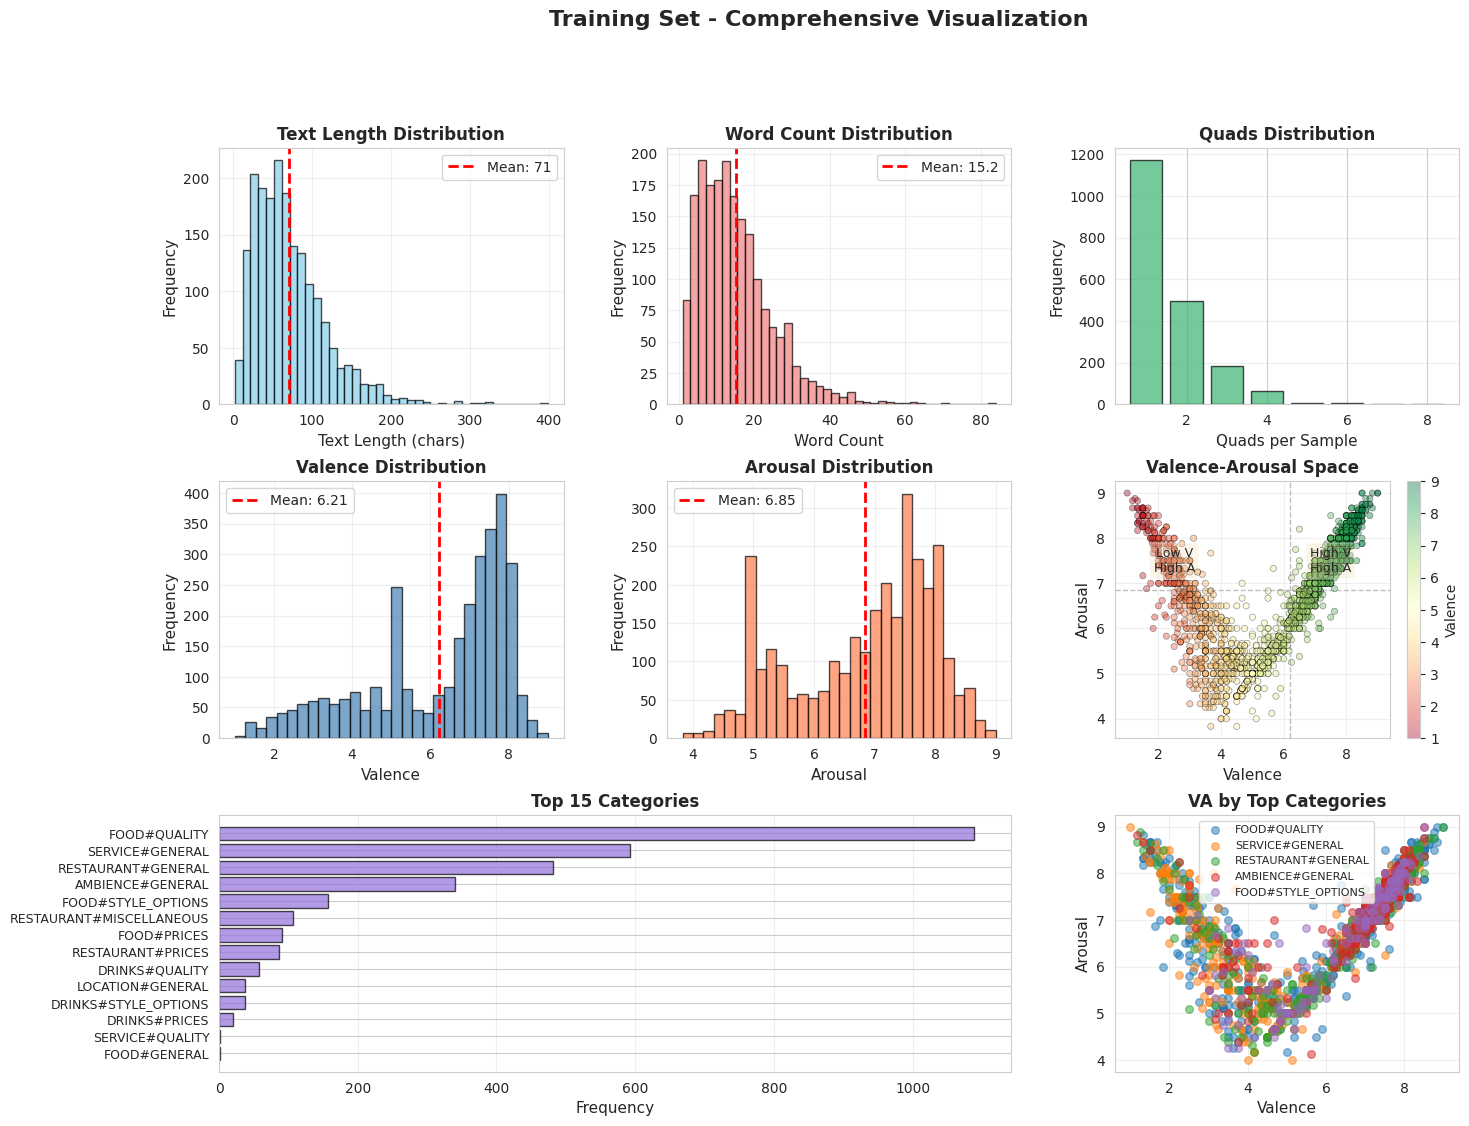

In [6]:
def visualize_data(df: pd.DataFrame, config: Config, title: str = "Dataset"):
    """
    Create comprehensive visualizations for the dataset.

    Args:
        df: DataFrame with data
        config: Configuration
        title: Title for plots
    """
    entity_col = 'Quadruplets' if config.subtask == 3 else 'Triplets'
    count_col = 'num_quads' if config.subtask == 3 else 'num_trips'

    # Skip if no labeled data
    if count_col not in df.columns or df[count_col].sum() == 0:
        print(f"⚠️ No labeled data in {title} - skipping visualization")
        return

    # Extract all entities for visualization
    all_valences = []
    all_arousals = []
    all_categories = []

    for entities_list in df[entity_col]:
        if isinstance(entities_list, list):
            for entity in entities_list:
                all_valences.append(entity.get('valence', 5.0))
                all_arousals.append(entity.get('arousal', 5.0))
                if config.subtask == 3:
                    all_categories.append(entity.get('category', 'NULL'))

    valences = np.array(all_valences)
    arousals = np.array(all_arousals)

    # Create visualizations
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Text length distribution
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(df['text_length'], bins=40, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df["text_length"].mean():.0f}')
    ax1.set_xlabel('Text Length (chars)', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Text Length Distribution', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Word count distribution
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(df['word_count'], bins=40, color='lightcoral', edgecolor='black', alpha=0.7)
    ax2.axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df["word_count"].mean():.1f}')
    ax2.set_xlabel('Word Count', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('Word Count Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Entities per sample
    ax3 = fig.add_subplot(gs[0, 2])
    entity_name = "Quads" if config.subtask == 3 else "Trips"
    counts = df[count_col].value_counts().sort_index()
    ax3.bar(counts.index, counts.values, color='mediumseagreen', edgecolor='black', alpha=0.7)
    ax3.set_xlabel(f'{entity_name} per Sample', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title(f'{entity_name} Distribution', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # 4. Valence distribution
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.hist(valences, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax4.axvline(valences.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {valences.mean():.2f}')
    ax4.set_xlabel('Valence', fontsize=11)
    ax4.set_ylabel('Frequency', fontsize=11)
    ax4.set_title('Valence Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Arousal distribution
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(arousals, bins=30, color='coral', edgecolor='black', alpha=0.7)
    ax5.axvline(arousals.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {arousals.mean():.2f}')
    ax5.set_xlabel('Arousal', fontsize=11)
    ax5.set_ylabel('Frequency', fontsize=11)
    ax5.set_title('Arousal Distribution', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. VA Scatter Plot (Valence-Arousal Space)
    ax6 = fig.add_subplot(gs[1, 2])
    scatter = ax6.scatter(valences, arousals, alpha=0.4, c=valences, cmap='RdYlGn',
                          s=20, edgecolors='black', linewidth=0.5)
    ax6.set_xlabel('Valence', fontsize=11)
    ax6.set_ylabel('Arousal', fontsize=11)
    ax6.set_title('Valence-Arousal Space', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3)

    # Add quadrants
    v_mean, a_mean = valences.mean(), arousals.mean()
    ax6.axvline(v_mean, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax6.axhline(a_mean, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # Add quadrant labels
    ax6.text(7.5, 7.5, 'High V\nHigh A', ha='center', va='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax6.text(2.5, 7.5, 'Low V\nHigh A', ha='center', va='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.colorbar(scatter, ax=ax6, label='Valence')

    # 7. Top Categories (if Subtask 3)
    if config.subtask == 3:
        ax7 = fig.add_subplot(gs[2, :2])
        category_counts = Counter(all_categories)
        top_cats = category_counts.most_common(15)

        cats, counts = zip(*top_cats) if top_cats else ([], [])
        y_pos = np.arange(len(cats))

        ax7.barh(y_pos, counts, color='mediumpurple', edgecolor='black', alpha=0.7)
        ax7.set_yticks(y_pos)
        ax7.set_yticklabels(cats, fontsize=9)
        ax7.set_xlabel('Frequency', fontsize=11)
        ax7.set_title('Top 15 Categories', fontsize=12, fontweight='bold')
        ax7.invert_yaxis()
        ax7.grid(True, alpha=0.3, axis='x')

        # 8. VA by Category (top categories)
        ax8 = fig.add_subplot(gs[2, 2])

        # Get top 5 categories
        top_5_cats = [cat for cat, _ in category_counts.most_common(5)]
        cat_va_data = {cat: {'v': [], 'a': []} for cat in top_5_cats}

        for entities_list in df[entity_col]:
            if isinstance(entities_list, list):
                for entity in entities_list:
                    cat = entity.get('category', 'NULL')
                    if cat in top_5_cats:
                        cat_va_data[cat]['v'].append(entity.get('valence', 5.0))
                        cat_va_data[cat]['a'].append(entity.get('arousal', 5.0))

        # Plot
        for i, cat in enumerate(top_5_cats):
            if cat_va_data[cat]['v']:
                v_vals = cat_va_data[cat]['v']
                a_vals = cat_va_data[cat]['a']
                ax8.scatter(v_vals, a_vals, alpha=0.5, s=30, label=cat[:20])

        ax8.set_xlabel('Valence', fontsize=11)
        ax8.set_ylabel('Arousal', fontsize=11)
        ax8.set_title('VA by Top Categories', fontsize=12, fontweight='bold')
        ax8.legend(fontsize=8, loc='best')
        ax8.grid(True, alpha=0.3)
    else:
        # For Subtask 2, show aspect/opinion word lengths
        ax7 = fig.add_subplot(gs[2, :])

        aspect_lengths = []
        opinion_lengths = []

        for entities_list in df[entity_col]:
            if isinstance(entities_list, list):
                for entity in entities_list:
                    asp = entity.get('aspect', 'NULL')
                    opn = entity.get('opinion', 'NULL')
                    if asp != 'NULL':
                        aspect_lengths.append(len(asp.split()))
                    if opn != 'NULL':
                        opinion_lengths.append(len(opn.split()))

        ax7.hist([aspect_lengths, opinion_lengths], bins=20, label=['Aspects', 'Opinions'],
                 color=['steelblue', 'coral'], edgecolor='black', alpha=0.7)
        ax7.set_xlabel('Word Count', fontsize=11)
        ax7.set_ylabel('Frequency', fontsize=11)
        ax7.set_title('Aspect & Opinion Length Distribution', fontsize=12, fontweight='bold')
        ax7.legend()
        ax7.grid(True, alpha=0.3)

    plt.suptitle(f'{title} - Comprehensive Visualization', fontsize=16, fontweight='bold', y=0.995)
    plt.show()

# Visualize training data
visualize_data(train_df, config, "Training Set")

## 🔤 Part 7: Tokenizer and Token Alignment

Initialize tokenizer and implement functions for aligning text spans (aspects/opinions) with tokenized sequences.

In [7]:
print("\n" + "=" * 80)
print("🔤 INITIALIZING TOKENIZER")
print("=" * 80)

tokenizer = AutoTokenizer.from_pretrained(config.model_name)
print(f"✅ Tokenizer loaded: {config.model_name}")
print(f"📏 Vocab size: {tokenizer.vocab_size}")
print(f"🔧 Special tokens: {tokenizer.special_tokens_map}")

# Test tokenization
test_text = "The food was absolutely amazing and delicious!"
test_encoding = tokenizer(test_text, return_offsets_mapping=True, add_special_tokens=True)

print(f"\n🔬 Test Tokenization:")
print(f"  Input: '{test_text}'")
print(f"  Tokens: {tokenizer.convert_ids_to_tokens(test_encoding['input_ids'])}")
print(f"  Offset mapping: {test_encoding['offset_mapping'][:10]}...")
print(f"  Number of tokens: {len(test_encoding['input_ids'])}")

print("=" * 80)


🔤 INITIALIZING TOKENIZER


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

✅ Tokenizer loaded: bert-base-multilingual-cased
📏 Vocab size: 119547
🔧 Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}

🔬 Test Tokenization:
  Input: 'The food was absolutely amazing and delicious!'
  Tokens: ['[CLS]', 'The', 'food', 'was', 'absolute', '##ly', 'ama', '##zing', 'and', 'del', '##icio', '##us', '!', '[SEP]']
  Offset mapping: [(0, 0), (0, 3), (4, 8), (9, 12), (13, 21), (21, 23), (24, 27), (27, 31), (32, 35), (36, 39)]...
  Number of tokens: 14


## 🎯 Part 8: Token Alignment Helper Functions

Critical functions to align character-level spans (aspects/opinions) with token-level BIO tags.

In [8]:
def find_span_in_text(text: str, span: str) -> List[Tuple[int, int]]:
    """
    Find all occurrences of a span in text (case-sensitive).

    Args:
        text: Full text
        span: Span to find

    Returns:
        List of (start, end) character positions
    """
    if span == 'NULL' or not span:
        return []

    positions = []
    start = 0
    span_lower = span.lower()
    text_lower = text.lower()

    while start < len(text):
        pos = text_lower.find(span_lower, start)
        if pos == -1:
            break
        positions.append((pos, pos + len(span)))
        start = pos + 1

    return positions


def align_span_to_tokens(
    text: str,
    span: str,
    offset_mapping: List[Tuple[int, int]],
    label_begin: str,
    label_inside: str,
    label_outside: str = 'O'
) -> List[str]:
    """
    Align a text span to BIO tags for tokens.

    Args:
        text: Original text
        span: Aspect or opinion span
        offset_mapping: Token offset mapping from tokenizer
        label_begin: Label for beginning token (e.g., 'B-ASP')
        label_inside: Label for inside tokens (e.g., 'I-ASP')
        label_outside: Label for outside tokens (default: 'O')

    Returns:
        List of BIO labels for each token
    """
    # Initialize all as outside
    labels = [label_outside] * len(offset_mapping)

    # Find span positions
    span_positions = find_span_in_text(text, span)

    if not span_positions:
        return labels

    # For each occurrence of the span
    for span_start, span_end in span_positions:
        first_token = True

        # Mark tokens that overlap with the span
        for i, (token_start, token_end) in enumerate(offset_mapping):
            # Skip special tokens (they have offset (0, 0))
            if token_start == token_end == 0:
                continue

            # Check if token overlaps with span
            if token_start < span_end and token_end > span_start:
                if first_token:
                    labels[i] = label_begin
                    first_token = False
                else:
                    labels[i] = label_inside

    return labels


def create_bio_labels_for_sample(
    text: str,
    entities: List[Dict],
    offset_mapping: List[Tuple[int, int]],
    config: Config
) -> Tuple[List[str], List[str]]:
    """
    Create BIO labels for aspects and opinions in a sample.

    Args:
        text: Original text
        entities: List of quadruplets/triplets
        offset_mapping: Token offset mapping
        config: Configuration

    Returns:
        (aspect_labels, opinion_labels) - both are lists of BIO tags
    """
    # Initialize with all 'O' (outside)
    aspect_labels = ['O'] * len(offset_mapping)
    opinion_labels = ['O'] * len(offset_mapping)

    # Process each entity
    for entity in entities:
        aspect = entity.get('aspect', 'NULL')
        opinion = entity.get('opinion', 'NULL')

        # Align aspect
        if aspect != 'NULL':
            asp_labels = align_span_to_tokens(
                text, aspect, offset_mapping,
                'B-ASP', 'I-ASP', 'O'
            )
            # Merge labels (prioritize non-O labels)
            for i in range(len(aspect_labels)):
                if asp_labels[i] != 'O':
                    aspect_labels[i] = asp_labels[i]

        # Align opinion
        if opinion != 'NULL':
            opn_labels = align_span_to_tokens(
                text, opinion, offset_mapping,
                'B-OPN', 'I-OPN', 'O'
            )
            # Merge labels
            for i in range(len(opinion_labels)):
                if opn_labels[i] != 'O':
                    opinion_labels[i] = opn_labels[i]

    return aspect_labels, opinion_labels


def aggregate_va_scores(entities: List[Dict]) -> Tuple[float, float]:
    """
    Aggregate VA scores from multiple entities.
    For simplicity, we take the mean. In practice, this is sample-level.

    Args:
        entities: List of entities with valence/arousal

    Returns:
        (mean_valence, mean_arousal)
    """
    if not entities:
        return 5.0, 5.0  # Neutral default

    valences = [e.get('valence', 5.0) for e in entities]
    arousals = [e.get('arousal', 5.0) for e in entities]

    return np.mean(valences), np.mean(arousals)


# Test alignment
print("\n" + "=" * 80)
print("🧪 TESTING TOKEN ALIGNMENT")
print("=" * 80)

test_text = "The food was amazing and the service was terrible"
test_entities = [
    {'aspect': 'food', 'opinion': 'amazing', 'valence': 8.0, 'arousal': 7.5},
    {'aspect': 'service', 'opinion': 'terrible', 'valence': 2.0, 'arousal': 7.0}
]

# Tokenize
encoding = tokenizer(
    test_text,
    return_offsets_mapping=True,
    add_special_tokens=True,
    padding=False,
    truncation=False
)

tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'])
offset_mapping = encoding['offset_mapping']

# Create BIO labels
aspect_labels, opinion_labels = create_bio_labels_for_sample(
    test_text, test_entities, offset_mapping, config
)

print(f"\nText: '{test_text}'")
print(f"\nEntities:")
for e in test_entities:
    print(f"  - Aspect: '{e['aspect']}', Opinion: '{e['opinion']}', VA: {e['valence']:.1f}#{e['arousal']:.1f}")

print(f"\n{'Token':<15} {'Offset':<12} {'Aspect':<10} {'Opinion':<10}")
print("-" * 50)
for i, (token, offset, asp, opn) in enumerate(zip(tokens, offset_mapping, aspect_labels, opinion_labels)):
    print(f"{token:<15} {str(offset):<12} {asp:<10} {opn:<10}")

print("=" * 80)


🧪 TESTING TOKEN ALIGNMENT

Text: 'The food was amazing and the service was terrible'

Entities:
  - Aspect: 'food', Opinion: 'amazing', VA: 8.0#7.5
  - Aspect: 'service', Opinion: 'terrible', VA: 2.0#7.0

Token           Offset       Aspect     Opinion   
--------------------------------------------------
[CLS]           (0, 0)       O          O         
The             (0, 3)       O          O         
food            (4, 8)       B-ASP      O         
was             (9, 12)      O          O         
ama             (13, 16)     O          B-OPN     
##zing          (16, 20)     O          I-OPN     
and             (21, 24)     O          O         
the             (25, 28)     O          O         
service         (29, 36)     B-ASP      O         
was             (37, 40)     O          O         
terrible        (41, 49)     O          B-OPN     
[SEP]           (0, 0)       O          O         


## 🏗️ Part 9: Multi-Task Dataset Class

PyTorch Dataset for multi-task learning with:
- Aspect extraction (BIO tagging)
- Opinion extraction (BIO tagging)
- Category classification (multi-label)
- VA regression (dual-head)

In [9]:
class MultiTaskDimABSADataset(Dataset):
    """
    Multi-Task Dataset for DimABSA Subtask 2 & 3.

    Outputs:
        - input_ids: Token IDs [max_length]
        - attention_mask: Attention mask [max_length]
        - aspect_labels: BIO labels for aspects [max_length]
        - opinion_labels: BIO labels for opinions [max_length]
        - category_labels: Multi-hot vector for categories [num_categories] (Task 3 only)
        - valence: Average valence score (float)
        - arousal: Average arousal score (float)
        - has_labels: Whether this sample has labels (False for test set)
    """

    def __init__(
        self,
        dataframe: pd.DataFrame,
        tokenizer,
        config: Config,
        is_test: bool = False
    ):
        """
        Initialize dataset.

        Args:
            dataframe: DataFrame with ID, Text, Quadruplets/Triplets
            tokenizer: HuggingFace tokenizer
            config: Configuration object
            is_test: Whether this is test data (no labels)
        """
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.config = config
        self.is_test = is_test
        self.entity_col = 'Quadruplets' if config.subtask == 3 else 'Triplets'

        # Label mappings
        self.aspect_label2id = config.aspect_label2id
        self.opinion_label2id = config.opinion_label2id
        if config.subtask == 3:
            self.category_label2id = config.category_label2id

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Get a single sample with all multi-task labels.

        Returns:
            Dictionary with input_ids, attention_mask, and task-specific labels
        """
        row = self.data.iloc[idx]
        text = str(row['Text'])
        entities = row[self.entity_col] if not self.is_test else []

        # Tokenize with offset mapping
        encoding = self.tokenizer(
            text,
            max_length=self.config.max_length,
            padding='max_length',
            truncation=True,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        # Extract tensors
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        offset_mapping = encoding['offset_mapping'].squeeze(0).tolist()

        # Initialize output
        item = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }

        # If test set, return without labels
        if self.is_test or not entities:
            item['has_labels'] = torch.tensor(False)
            # Add dummy labels for compatibility
            item['aspect_labels'] = torch.zeros(self.config.max_length, dtype=torch.long)
            item['opinion_labels'] = torch.zeros(self.config.max_length, dtype=torch.long)
            if self.config.subtask == 3:
                item['category_labels'] = torch.zeros(len(self.config.category_labels), dtype=torch.float32)
            item['valence'] = torch.tensor(5.0, dtype=torch.float32)
            item['arousal'] = torch.tensor(5.0, dtype=torch.float32)
            return item

        # Create BIO labels for aspects and opinions
        aspect_bio_labels, opinion_bio_labels = create_bio_labels_for_sample(
            text, entities, offset_mapping, self.config
        )

        # Convert BIO labels to IDs
        aspect_label_ids = [self.aspect_label2id[label] for label in aspect_bio_labels]
        opinion_label_ids = [self.opinion_label2id[label] for label in opinion_bio_labels]

        # Pad/truncate to max_length
        aspect_label_ids = aspect_label_ids[:self.config.max_length]
        opinion_label_ids = opinion_label_ids[:self.config.max_length]

        # Pad if necessary
        while len(aspect_label_ids) < self.config.max_length:
            aspect_label_ids.append(self.aspect_label2id['O'])
        while len(opinion_label_ids) < self.config.max_length:
            opinion_label_ids.append(self.opinion_label2id['O'])

        item['aspect_labels'] = torch.tensor(aspect_label_ids, dtype=torch.long)
        item['opinion_labels'] = torch.tensor(opinion_label_ids, dtype=torch.long)

        # Category labels (multi-hot encoding) - Task 3 only
        if self.config.subtask == 3:
            category_vector = torch.zeros(len(self.config.category_labels), dtype=torch.float32)
            for entity in entities:
                category = entity.get('category', 'NULL')
                if category in self.category_label2id:
                    cat_idx = self.category_label2id[category]
                    category_vector[cat_idx] = 1.0
            item['category_labels'] = category_vector

        # VA regression targets (average across entities)
        valence, arousal = aggregate_va_scores(entities)
        item['valence'] = torch.tensor(valence, dtype=torch.float32)
        item['arousal'] = torch.tensor(arousal, dtype=torch.float32)

        item['has_labels'] = torch.tensor(True)

        return item


# Create datasets
print("\n" + "=" * 80)
print("🏗️ CREATING DATASETS")
print("=" * 80)

train_dataset = MultiTaskDimABSADataset(
    train_df, tokenizer, config, is_test=False
)

val_dataset = MultiTaskDimABSADataset(
    val_df, tokenizer, config, is_test=False
)

test_dataset = MultiTaskDimABSADataset(
    test_df, tokenizer, config, is_test=True
)

print(f"✅ Datasets created:")
print(f"   Train: {len(train_dataset):,} samples")
print(f"   Val:   {len(val_dataset):,} samples")
print(f"   Test:  {len(test_dataset):,} samples")

# Test a sample
print(f"\n🔬 Sample from training dataset:")
sample = train_dataset[0]
print(f"   Input IDs shape:      {sample['input_ids'].shape}")
print(f"   Attention mask shape: {sample['attention_mask'].shape}")
print(f"   Aspect labels shape:  {sample['aspect_labels'].shape}")
print(f"   Opinion labels shape: {sample['opinion_labels'].shape}")
if config.subtask == 3:
    print(f"   Category labels shape: {sample['category_labels'].shape}")
    print(f"   Active categories:     {sample['category_labels'].sum().item():.0f}")
print(f"   Valence:              {sample['valence'].item():.2f}")
print(f"   Arousal:              {sample['arousal'].item():.2f}")
print(f"   Has labels:           {sample['has_labels'].item()}")

# Decode tokens and show labels
tokens = tokenizer.convert_ids_to_tokens(sample['input_ids'])
aspect_labels = [config.aspect_id2label[id.item()] for id in sample['aspect_labels']]
opinion_labels = [config.opinion_id2label[id.item()] for id in sample['opinion_labels']]

print(f"\n🔍 First 15 tokens with labels:")
print(f"   {'Token':<15} {'Aspect':<10} {'Opinion':<10}")
print("   " + "-" * 40)
for i in range(min(15, len(tokens))):
    if tokens[i] not in ['[PAD]', tokenizer.pad_token]:
        print(f"   {tokens[i]:<15} {aspect_labels[i]:<10} {opinion_labels[i]:<10}")

print("=" * 80)


🏗️ CREATING DATASETS
✅ Datasets created:
   Train: 1,941 samples
   Val:   343 samples
   Test:  200 samples

🔬 Sample from training dataset:
   Input IDs shape:      torch.Size([256])
   Attention mask shape: torch.Size([256])
   Aspect labels shape:  torch.Size([256])
   Opinion labels shape: torch.Size([256])
   Category labels shape: torch.Size([31])
   Active categories:     1
   Valence:              7.00
   Arousal:              6.80
   Has labels:           True

🔍 First 15 tokens with labels:
   Token           Aspect     Opinion   
   ----------------------------------------
   [CLS]           O          O         
   always          O          B-OPN     
   good            O          I-OPN     
   .               O          O         
   [SEP]           O          O         


## 📦 Part 10: DataLoader Creation

Create efficient DataLoaders with proper batching for multi-task learning.

In [10]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("\n" + "=" * 80)
print("📦 DATALOADERS CREATED")
print("=" * 80)
print(f"Train batches: {len(train_loader):,}")
print(f"Val batches:   {len(val_loader):,}")
print(f"Test batches:  {len(test_loader):,}")

# Test a batch
print(f"\n🔬 Sample batch from training:")
batch = next(iter(train_loader))
print(f"   Batch size:           {batch['input_ids'].shape[0]}")
print(f"   Input IDs shape:      {batch['input_ids'].shape}")
print(f"   Attention mask shape: {batch['attention_mask'].shape}")
print(f"   Aspect labels shape:  {batch['aspect_labels'].shape}")
print(f"   Opinion labels shape: {batch['opinion_labels'].shape}")
if config.subtask == 3:
    print(f"   Category labels shape: {batch['category_labels'].shape}")
print(f"   Valence shape:        {batch['valence'].shape}")
print(f"   Arousal shape:        {batch['arousal'].shape}")

# Show statistics
print(f"\n📊 Batch statistics:")
print(f"   Avg valence: {batch['valence'].mean().item():.2f}")
print(f"   Avg arousal: {batch['arousal'].mean().item():.2f}")
print(f"   Samples with aspect tags:  {(batch['aspect_labels'] != config.aspect_label2id['O']).any(dim=1).sum().item()}/{batch['input_ids'].shape[0]}")
print(f"   Samples with opinion tags: {(batch['opinion_labels'] != config.opinion_label2id['O']).any(dim=1).sum().item()}/{batch['input_ids'].shape[0]}")

print("=" * 80)


📦 DATALOADERS CREATED
Train batches: 243
Val batches:   43
Test batches:  25

🔬 Sample batch from training:
   Batch size:           8
   Input IDs shape:      torch.Size([8, 256])
   Attention mask shape: torch.Size([8, 256])
   Aspect labels shape:  torch.Size([8, 256])
   Opinion labels shape: torch.Size([8, 256])
   Category labels shape: torch.Size([8, 31])
   Valence shape:        torch.Size([8])
   Arousal shape:        torch.Size([8])

📊 Batch statistics:
   Avg valence: 6.69
   Avg arousal: 6.72
   Samples with aspect tags:  5/8
   Samples with opinion tags: 7/8


## 🧠 Part 11: Multi-Task Model Architecture

Advanced transformer-based model with multiple task-specific heads:
- **Sequence Tagging Heads**: For aspect and opinion extraction (BIO)
- **Classification Head**: For category prediction (multi-label)
- **Regression Heads**: For valence and arousal prediction (dual-head)

In [11]:
class MultiTaskDimABSAModel(nn.Module):
    """
    Multi-Task Model for DimABSA Subtask 2 & 3.

    Architecture:
        1. Transformer Encoder (BERT/XLM-RoBERTa/etc.)
        2. Multi-Task Heads:
           - Aspect Tagger (token-level classification)
           - Opinion Tagger (token-level classification)
           - Category Classifier (sentence-level multi-label)
           - VA Regressor (sentence-level regression with dual heads)

    Args:
        config: Configuration object
    """

    def __init__(self, config: Config):
        super(MultiTaskDimABSAModel, self).__init__()

        self.config = config

        # Load pretrained transformer
        self.transformer_config = AutoConfig.from_pretrained(config.model_name)
        self.transformer = AutoModel.from_pretrained(config.model_name)

        hidden_size = self.transformer_config.hidden_size

        # Dropout for regularization
        self.dropout = nn.Dropout(config.dropout_rate)

        # ============ Task 1: Aspect Tagging (BIO) ============
        self.aspect_tagger = nn.Linear(hidden_size, len(config.aspect_labels))

        # ============ Task 2: Opinion Tagging (BIO) ============
        self.opinion_tagger = nn.Linear(hidden_size, len(config.opinion_labels))

        # ============ Task 3: Category Classification (Multi-Label) ============
        if config.subtask == 3:
            # Two-layer feedforward for category classification
            self.category_fc1 = nn.Linear(hidden_size, hidden_size // 2)
            self.category_fc2 = nn.Linear(hidden_size // 2, len(config.category_labels))
            self.category_activation = nn.GELU()
            self.category_dropout = nn.Dropout(config.dropout_rate)

        # ============ Task 4: VA Regression ============
        # Shared layer for VA
        self.va_fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.va_activation = nn.GELU()
        self.va_dropout = nn.Dropout(config.dropout_rate)

        # Separate heads for Valence and Arousal
        self.valence_head = nn.Linear(hidden_size // 2, 1)
        self.arousal_head = nn.Linear(hidden_size // 2, 1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize task-specific head weights"""
        # Aspect tagger
        nn.init.xavier_uniform_(self.aspect_tagger.weight)
        nn.init.zeros_(self.aspect_tagger.bias)

        # Opinion tagger
        nn.init.xavier_uniform_(self.opinion_tagger.weight)
        nn.init.zeros_(self.opinion_tagger.bias)

        # Category classifier
        if self.config.subtask == 3:
            nn.init.xavier_uniform_(self.category_fc1.weight)
            nn.init.zeros_(self.category_fc1.bias)
            nn.init.xavier_uniform_(self.category_fc2.weight)
            nn.init.zeros_(self.category_fc2.bias)

        # VA regressor
        nn.init.xavier_uniform_(self.va_fc1.weight)
        nn.init.zeros_(self.va_fc1.bias)
        nn.init.xavier_uniform_(self.valence_head.weight)
        nn.init.zeros_(self.valence_head.bias)
        nn.init.xavier_uniform_(self.arousal_head.weight)
        nn.init.zeros_(self.arousal_head.bias)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        return_all: bool = True
    ) -> Dict[str, torch.Tensor]:
        """
        Forward pass.

        Args:
            input_ids: [batch_size, seq_len]
            attention_mask: [batch_size, seq_len]
            return_all: Whether to return all task outputs

        Returns:
            Dictionary with:
            - aspect_logits: [batch_size, seq_len, num_aspect_labels]
            - opinion_logits: [batch_size, seq_len, num_opinion_labels]
            - category_logits: [batch_size, num_categories] (if subtask 3)
            - valence: [batch_size, 1]
            - arousal: [batch_size, 1]
        """
        # Get transformer outputs
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        # Token-level representations: [batch_size, seq_len, hidden_size]
        sequence_output = outputs.last_hidden_state
        sequence_output = self.dropout(sequence_output)

        # Sentence-level representation: [batch_size, hidden_size]
        # Use [CLS] token (first token)
        pooled_output = sequence_output[:, 0, :]

        results = {}

        # ============ Aspect Tagging ============
        aspect_logits = self.aspect_tagger(sequence_output)  # [batch, seq_len, num_aspect_labels]
        results['aspect_logits'] = aspect_logits

        # ============ Opinion Tagging ============
        opinion_logits = self.opinion_tagger(sequence_output)  # [batch, seq_len, num_opinion_labels]
        results['opinion_logits'] = opinion_logits

        # ============ Category Classification ============
        if self.config.subtask == 3:
            cat_hidden = self.category_fc1(pooled_output)
            cat_hidden = self.category_activation(cat_hidden)
            cat_hidden = self.category_dropout(cat_hidden)
            category_logits = self.category_fc2(cat_hidden)  # [batch, num_categories]
            results['category_logits'] = category_logits

        # ============ VA Regression ============
        va_hidden = self.va_fc1(pooled_output)
        va_hidden = self.va_activation(va_hidden)
        va_hidden = self.va_dropout(va_hidden)

        valence = self.valence_head(va_hidden)  # [batch, 1]
        arousal = self.arousal_head(va_hidden)  # [batch, 1]

        # Clamp to [va_min, va_max]
        valence = torch.clamp(valence, self.config.va_min, self.config.va_max)
        arousal = torch.clamp(arousal, self.config.va_min, self.config.va_max)

        results['valence'] = valence.squeeze(-1)  # [batch]
        results['arousal'] = arousal.squeeze(-1)  # [batch]

        return results


# Initialize model
print("\n" + "=" * 80)
print("🧠 INITIALIZING MODEL")
print("=" * 80)

model = MultiTaskDimABSAModel(config)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
transformer_params = sum(p.numel() for p in model.transformer.parameters())
head_params = total_params - transformer_params

print(f"\n📊 Model Architecture:")
print(f"   Base Model:           {config.model_name}")
print(f"   Hidden Size:          {model.transformer_config.hidden_size}")
print(f"   Number of Layers:     {model.transformer_config.num_hidden_layers}")

print(f"\n📊 Parameter Counts:")
print(f"   Total parameters:     {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Transformer params:   {transformer_params:,}")
print(f"   Task heads params:    {head_params:,}")
print(f"   Model size:           {total_params * 4 / 1e6:.2f} MB")

print(f"\n🎯 Task Heads:")
print(f"   Aspect tagger:        {len(config.aspect_labels)} labels (BIO)")
print(f"   Opinion tagger:       {len(config.opinion_labels)} labels (BIO)")
if config.subtask == 3:
    print(f"   Category classifier:  {len(config.category_labels)} categories (multi-label)")
print(f"   Valence regressor:    1 output (regression)")
print(f"   Arousal regressor:    1 output (regression)")

# Test forward pass
print(f"\n🔬 Testing forward pass...")
batch = next(iter(train_loader))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask)

    print(f"   ✅ Aspect logits shape:   {outputs['aspect_logits'].shape}")
    print(f"   ✅ Opinion logits shape:  {outputs['opinion_logits'].shape}")
    if config.subtask == 3:
        print(f"   ✅ Category logits shape: {outputs['category_logits'].shape}")
    print(f"   ✅ Valence shape:         {outputs['valence'].shape}")
    print(f"   ✅ Arousal shape:         {outputs['arousal'].shape}")

    print(f"\n   Sample predictions:")
    print(f"   Valence: {outputs['valence'][0].item():.2f}")
    print(f"   Arousal: {outputs['arousal'][0].item():.2f}")

print("=" * 80)


🧠 INITIALIZING MODEL


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


📊 Model Architecture:
   Base Model:           bert-base-multilingual-cased
   Hidden Size:          768
   Number of Layers:     12

📊 Parameter Counts:
   Total parameters:     178,461,351
   Trainable parameters: 178,461,351
   Transformer params:   177,853,440
   Task heads params:    607,911
   Model size:           713.85 MB

🎯 Task Heads:
   Aspect tagger:        3 labels (BIO)
   Opinion tagger:       3 labels (BIO)
   Category classifier:  31 categories (multi-label)
   Valence regressor:    1 output (regression)
   Arousal regressor:    1 output (regression)

🔬 Testing forward pass...
   ✅ Aspect logits shape:   torch.Size([8, 256, 3])
   ✅ Opinion logits shape:  torch.Size([8, 256, 3])
   ✅ Category logits shape: torch.Size([8, 31])
   ✅ Valence shape:         torch.Size([8])
   ✅ Arousal shape:         torch.Size([8])

   Sample predictions:
   Valence: 1.00
   Arousal: 1.00


## 📐 Part 12: Multi-Task Loss Function

Comprehensive loss function combining:
- Cross-Entropy for sequence tagging (Aspect & Opinion)
- Binary Cross-Entropy for multi-label category classification
- MSE for VA regression (Valence & Arousal)

In [12]:
class MultiTaskLoss(nn.Module):
    """
    Multi-Task Loss for DimABSA.

    Combines:
    1. Cross-Entropy Loss for Aspect tagging
    2. Cross-Entropy Loss for Opinion tagging
    3. Binary Cross-Entropy Loss for Category classification (Task 3)
    4. MSE Loss for Valence regression
    5. MSE Loss for Arousal regression

    Each loss is weighted according to config.
    """

    def __init__(self, config: Config):
        super(MultiTaskLoss, self).__init__()

        self.config = config

        # Cross-Entropy for sequence tagging (ignores padding)
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=-100)

        # Binary Cross-Entropy for multi-label classification
        if config.subtask == 3:
            self.bce_loss = nn.BCEWithLogitsLoss()

        # MSE for regression
        self.mse_loss = nn.MSELoss()

        # Loss weights
        self.w_aspect = config.loss_weight_aspect
        self.w_opinion = config.loss_weight_opinion
        self.w_category = config.loss_weight_category if config.subtask == 3 else 0.0
        self.w_valence = config.loss_weight_valence
        self.w_arousal = config.loss_weight_arousal

    def forward(
        self,
        outputs: Dict[str, torch.Tensor],
        batch: Dict[str, torch.Tensor],
        attention_mask: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        Compute multi-task loss.

        Args:
            outputs: Model outputs
            batch: Batch with labels
            attention_mask: Attention mask for sequence tagging

        Returns:
            (total_loss, loss_dict) - total loss and individual losses
        """
        losses = {}

        # ============ Aspect Tagging Loss ============
        aspect_logits = outputs['aspect_logits']  # [batch, seq_len, num_labels]
        aspect_labels = batch['aspect_labels']    # [batch, seq_len]

        # Mask padding tokens
        active_loss = attention_mask.view(-1) == 1
        active_logits = aspect_logits.view(-1, aspect_logits.shape[-1])[active_loss]
        active_labels = aspect_labels.view(-1)[active_loss]

        loss_aspect = self.ce_loss(active_logits, active_labels)
        losses['aspect'] = loss_aspect.item()

        # ============ Opinion Tagging Loss ============
        opinion_logits = outputs['opinion_logits']
        opinion_labels = batch['opinion_labels']

        active_logits = opinion_logits.view(-1, opinion_logits.shape[-1])[active_loss]
        active_labels = opinion_labels.view(-1)[active_loss]

        loss_opinion = self.ce_loss(active_logits, active_labels)
        losses['opinion'] = loss_opinion.item()

        # ============ Category Classification Loss ============
        loss_category = torch.tensor(0.0, device=aspect_logits.device)
        if self.config.subtask == 3:
            category_logits = outputs['category_logits']  # [batch, num_categories]
            category_labels = batch['category_labels']    # [batch, num_categories]

            loss_category = self.bce_loss(category_logits, category_labels)
            losses['category'] = loss_category.item()

        # ============ Valence Regression Loss ============
        valence_pred = outputs['valence']  # [batch]
        valence_true = batch['valence']    # [batch]

        loss_valence = self.mse_loss(valence_pred, valence_true)
        losses['valence'] = loss_valence.item()

        # ============ Arousal Regression Loss ============
        arousal_pred = outputs['arousal']
        arousal_true = batch['arousal']

        loss_arousal = self.mse_loss(arousal_pred, arousal_true)
        losses['arousal'] = loss_arousal.item()

        # ============ Total Weighted Loss ============
        total_loss = (
            self.w_aspect * loss_aspect +
            self.w_opinion * loss_opinion +
            self.w_category * loss_category +
            self.w_valence * loss_valence +
            self.w_arousal * loss_arousal
        )

        losses['total'] = total_loss.item()

        return total_loss, losses


# Initialize loss function
criterion = MultiTaskLoss(config)

print("\n" + "=" * 80)
print("📐 LOSS FUNCTION")
print("=" * 80)
print(f"Multi-Task Loss with weighted components:")
print(f"   Aspect tagging:      weight = {config.loss_weight_aspect}")
print(f"   Opinion tagging:     weight = {config.loss_weight_opinion}")
if config.subtask == 3:
    print(f"   Category classification: weight = {config.loss_weight_category}")
print(f"   Valence regression:  weight = {config.loss_weight_valence}")
print(f"   Arousal regression:  weight = {config.loss_weight_arousal}")

# Test loss computation
print(f"\n🔬 Testing loss computation...")
batch = next(iter(train_loader))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)

# Move all labels to device
for key in ['aspect_labels', 'opinion_labels', 'valence', 'arousal']:
    if key in batch:
        batch[key] = batch[key].to(device)
if 'category_labels' in batch:
    batch['category_labels'] = batch['category_labels'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    total_loss, loss_dict = criterion(outputs, batch, attention_mask)

    print(f"   ✅ Total loss:     {total_loss.item():.4f}")
    print(f"   Component losses:")
    for name, value in loss_dict.items():
        if name != 'total':
            print(f"      - {name:12s}: {value:.4f}")

print("=" * 80)


📐 LOSS FUNCTION
Multi-Task Loss with weighted components:
   Aspect tagging:      weight = 1.0
   Opinion tagging:     weight = 1.0
   Category classification: weight = 1.0
   Valence regression:  weight = 1.0
   Arousal regression:  weight = 1.0

🔬 Testing loss computation...
   ✅ Total loss:     63.8732
   Component losses:
      - aspect      : 1.1158
      - opinion     : 1.2205
      - category    : 0.7284
      - valence     : 27.7136
      - arousal     : 33.0950


# 🚀 PART 2: Training, Evaluation & Submission

---

## 🔧 Part 13: Optimizer and Scheduler Setup

Configure optimizer with layer-wise learning rates and advanced scheduling.

In [13]:
# Prepare optimizer with layer-wise learning rate decay
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']

optimizer_grouped_parameters = [
    # Transformer parameters with decay
    {
        'params': [p for n, p in model.transformer.named_parameters()
                   if not any(nd in n for nd in no_decay)],
        'weight_decay': config.weight_decay,
        'lr': config.learning_rate
    },
    # Transformer parameters without decay
    {
        'params': [p for n, p in model.transformer.named_parameters()
                   if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
        'lr': config.learning_rate
    },
    # Task-specific heads with higher learning rate (10x)
    {
        'params': [p for n, p in model.named_parameters()
                   if 'transformer' not in n and not any(nd in n for nd in no_decay)],
        'weight_decay': config.weight_decay,
        'lr': config.learning_rate * 10
    },
    {
        'params': [p for n, p in model.named_parameters()
                   if 'transformer' not in n and any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
        'lr': config.learning_rate * 10
    }
]

optimizer = AdamW(optimizer_grouped_parameters, eps=1e-8)

# Calculate total training steps
total_steps = len(train_loader) * config.num_epochs
warmup_steps = int(total_steps * config.warmup_ratio)

# Create scheduler
if config.use_scheduler:
    if config.scheduler_type == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
    elif config.scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=total_steps,
            eta_min=1e-7
        )
    elif config.scheduler_type == 'plateau':
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            verbose=True
        )
else:
    scheduler = None

print("\n" + "=" * 80)
print("🔧 OPTIMIZER AND SCHEDULER")
print("=" * 80)
print(f"✅ Optimizer: AdamW")
print(f"   Base LR (transformer):  {config.learning_rate}")
print(f"   Task heads LR:          {config.learning_rate * 10}")
print(f"   Weight decay:           {config.weight_decay}")
print(f"   Parameter groups:       {len(optimizer_grouped_parameters)}")

print(f"\n✅ Scheduler: {config.scheduler_type if config.use_scheduler else 'None'}")
print(f"   Total steps:    {total_steps:,}")
print(f"   Warmup steps:   {warmup_steps:,}")
print(f"   Warmup ratio:   {config.warmup_ratio}")

print("=" * 80)


🔧 OPTIMIZER AND SCHEDULER
✅ Optimizer: AdamW
   Base LR (transformer):  2e-05
   Task heads LR:          0.0002
   Weight decay:           0.01
   Parameter groups:       4

✅ Scheduler: linear
   Total steps:    2,430
   Warmup steps:   243
   Warmup ratio:   0.1


## 📏 Part 14: Evaluation Metrics

Comprehensive metrics for multi-task evaluation:
- Sequence tagging: Precision, Recall, F1 (token-level and entity-level)
- VA regression: RMSE, MAE
- Category classification: Precision, Recall, F1 (multi-label)

In [14]:
def compute_sequence_tagging_metrics(
    predictions: np.ndarray,
    labels: np.ndarray,
    attention_mask: np.ndarray,
    label2id: Dict[str, int]
) -> Dict[str, float]:
    """
    Compute token-level metrics for sequence tagging.

    Args:
        predictions: Predicted label IDs [batch, seq_len]
        labels: True label IDs [batch, seq_len]
        attention_mask: Mask for valid tokens [batch, seq_len]
        label2id: Label to ID mapping

    Returns:
        Dictionary with precision, recall, f1
    """
    # Flatten and filter by attention mask
    predictions_flat = predictions[attention_mask == 1]
    labels_flat = labels[attention_mask == 1]

    # Remove 'O' labels for entity-level metrics
    id2label = {v: k for k, v in label2id.items()}
    O_id = label2id['O']

    # Get non-O indices
    non_o_mask = labels_flat != O_id

    if non_o_mask.sum() == 0:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    # Compute metrics (micro-average)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_flat[non_o_mask],
        predictions_flat[non_o_mask],
        average='micro',
        zero_division=0
    )

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


def compute_va_metrics(
    predictions: np.ndarray,
    labels: np.ndarray
) -> Dict[str, float]:
    """
    Compute regression metrics for VA scores.

    Args:
        predictions: Predicted VA scores [batch, 2] or [batch]
        labels: True VA scores [batch, 2] or [batch]

    Returns:
        Dictionary with RMSE and MAE
    """
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    mae = np.mean(np.abs(predictions - labels))

    return {
        'rmse': rmse,
        'mae': mae
    }


def compute_category_metrics(
    predictions: np.ndarray,
    labels: np.ndarray,
    threshold: float = 0.5
) -> Dict[str, float]:
    """
    Compute multi-label classification metrics.

    Args:
        predictions: Predicted logits [batch, num_categories]
        labels: True binary labels [batch, num_categories]
        threshold: Classification threshold

    Returns:
        Dictionary with precision, recall, f1
    """
    # Apply sigmoid and threshold
    predictions_binary = (torch.sigmoid(torch.from_numpy(predictions)) > threshold).numpy()

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels.astype(int),
        predictions_binary.astype(int),
        average='micro',
        zero_division=0
    )

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


print("✅ Evaluation metrics functions defined!")

✅ Evaluation metrics functions defined!


## 🏋️ Part 15: Training and Validation Functions

Comprehensive training and validation with multi-task metric tracking.

In [15]:
def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: MultiTaskLoss,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[object],
    device: torch.device,
    epoch: int,
    config: Config
) -> Dict[str, float]:
    """
    Train for one epoch.

    Returns:
        Dictionary with average metrics
    """
    model.train()

    # Accumulators
    total_losses = defaultdict(float)
    num_batches = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)

    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Move labels to device
        batch_device = {}
        for key in ['aspect_labels', 'opinion_labels', 'valence', 'arousal', 'has_labels']:
            if key in batch:
                batch_device[key] = batch[key].to(device)
        if config.subtask == 3 and 'category_labels' in batch:
            batch_device['category_labels'] = batch['category_labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss, loss_dict = criterion(outputs, batch_device, attention_mask)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)

        # Optimizer step
        optimizer.step()

        # Scheduler step (if not plateau)
        if scheduler is not None and config.scheduler_type != 'plateau':
            scheduler.step()

        # Accumulate losses
        for key, value in loss_dict.items():
            total_losses[key] += value
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })

    # Average losses
    avg_losses = {key: value / num_batches for key, value in total_losses.items()}
    avg_losses['lr'] = optimizer.param_groups[0]['lr']

    return avg_losses


def validate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: MultiTaskLoss,
    device: torch.device,
    config: Config
) -> Dict[str, float]:
    """
    Validate the model.

    Returns:
        Dictionary with metrics
    """
    model.eval()

    # Accumulators
    total_losses = defaultdict(float)
    num_batches = 0

    # Predictions and labels for metrics
    all_aspect_preds = []
    all_aspect_labels = []
    all_opinion_preds = []
    all_opinion_labels = []
    all_category_preds = []
    all_category_labels = []
    all_valence_preds = []
    all_valence_labels = []
    all_arousal_preds = []
    all_arousal_labels = []
    all_masks = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            # Move to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Move labels to device
            batch_device = {}
            for key in ['aspect_labels', 'opinion_labels', 'valence', 'arousal', 'has_labels']:
                if key in batch:
                    batch_device[key] = batch[key].to(device)
            if config.subtask == 3 and 'category_labels' in batch:
                batch_device['category_labels'] = batch['category_labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss, loss_dict = criterion(outputs, batch_device, attention_mask)

            # Accumulate losses
            for key, value in loss_dict.items():
                total_losses[key] += value
            num_batches += 1

            # Collect predictions
            all_aspect_preds.append(outputs['aspect_logits'].argmax(dim=-1).cpu().numpy())
            all_aspect_labels.append(batch_device['aspect_labels'].cpu().numpy())

            all_opinion_preds.append(outputs['opinion_logits'].argmax(dim=-1).cpu().numpy())
            all_opinion_labels.append(batch_device['opinion_labels'].cpu().numpy())

            if config.subtask == 3:
                all_category_preds.append(outputs['category_logits'].cpu().numpy())
                all_category_labels.append(batch_device['category_labels'].cpu().numpy())

            all_valence_preds.append(outputs['valence'].cpu().numpy())
            all_valence_labels.append(batch_device['valence'].cpu().numpy())

            all_arousal_preds.append(outputs['arousal'].cpu().numpy())
            all_arousal_labels.append(batch_device['arousal'].cpu().numpy())

            all_masks.append(attention_mask.cpu().numpy())

    # Average losses
    avg_losses = {key: value / num_batches for key, value in total_losses.items()}

    # Concatenate predictions
    aspect_preds = np.concatenate(all_aspect_preds, axis=0)
    aspect_labels = np.concatenate(all_aspect_labels, axis=0)
    opinion_preds = np.concatenate(all_opinion_preds, axis=0)
    opinion_labels = np.concatenate(all_opinion_labels, axis=0)
    masks = np.concatenate(all_masks, axis=0)

    valence_preds = np.concatenate(all_valence_preds)
    valence_labels = np.concatenate(all_valence_labels)
    arousal_preds = np.concatenate(all_arousal_preds)
    arousal_labels = np.concatenate(all_arousal_labels)

    # Compute metrics
    aspect_metrics = compute_sequence_tagging_metrics(
        aspect_preds, aspect_labels, masks, config.aspect_label2id
    )
    opinion_metrics = compute_sequence_tagging_metrics(
        opinion_preds, opinion_labels, masks, config.opinion_label2id
    )

    valence_metrics = compute_va_metrics(valence_preds, valence_labels)
    arousal_metrics = compute_va_metrics(arousal_preds, arousal_labels)

    # Combine metrics
    metrics = {
        **avg_losses,
        'aspect_f1': aspect_metrics['f1'],
        'aspect_precision': aspect_metrics['precision'],
        'aspect_recall': aspect_metrics['recall'],
        'opinion_f1': opinion_metrics['f1'],
        'opinion_precision': opinion_metrics['precision'],
        'opinion_recall': opinion_metrics['recall'],
        'valence_rmse': valence_metrics['rmse'],
        'valence_mae': valence_metrics['mae'],
        'arousal_rmse': arousal_metrics['rmse'],
        'arousal_mae': arousal_metrics['mae'],
    }

    # Category metrics (if Task 3)
    if config.subtask == 3:
        category_preds = np.concatenate(all_category_preds, axis=0)
        category_labels = np.concatenate(all_category_labels, axis=0)
        category_metrics = compute_category_metrics(category_preds, category_labels)

        metrics['category_f1'] = category_metrics['f1']
        metrics['category_precision'] = category_metrics['precision']
        metrics['category_recall'] = category_metrics['recall']

    return metrics


print("✅ Training and validation functions defined!")

✅ Training and validation functions defined!


## 🎯 Part 16: Main Training Loop

Execute the complete training process with multi-task metric tracking and checkpointing.

In [16]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_aspect_f1': [],
    'val_opinion_f1': [],
    'val_valence_rmse': [],
    'val_arousal_rmse': [],
    'learning_rates': []
}

if config.subtask == 3:
    history['val_category_f1'] = []

best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0
early_stop_patience = 3

print("\n" + "=" * 80)
print("🎯 STARTING TRAINING")
print("=" * 80)
print(f"Total epochs: {config.num_epochs}")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Early stopping patience: {early_stop_patience}")
print("=" * 80)

for epoch in range(1, config.num_epochs + 1):
    print(f"\n{'='*80}")
    print(f"📍 EPOCH {epoch}/{config.num_epochs}")
    print(f"{'='*80}")

    # Training
    train_metrics = train_epoch(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epoch=epoch,
        config=config
    )

    # Validation
    val_metrics = validate(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device,
        config=config
    )

    # Update scheduler (if plateau)
    if scheduler is not None and config.scheduler_type == 'plateau':
        scheduler.step(val_metrics['total'])

    # Save history
    history['train_loss'].append(train_metrics['total'])
    history['val_loss'].append(val_metrics['total'])
    history['val_aspect_f1'].append(val_metrics['aspect_f1'])
    history['val_opinion_f1'].append(val_metrics['opinion_f1'])
    history['val_valence_rmse'].append(val_metrics['valence_rmse'])
    history['val_arousal_rmse'].append(val_metrics['arousal_rmse'])
    history['learning_rates'].append(train_metrics['lr'])

    if config.subtask == 3:
        history['val_category_f1'].append(val_metrics['category_f1'])

    # Print metrics
    print(f"\n📊 Training Metrics:")
    print(f"   Loss: {train_metrics['total']:.4f}")

    print(f"\n📊 Validation Metrics:")
    print(f"   Total Loss:      {val_metrics['total']:.4f}")
    print(f"   Aspect F1:       {val_metrics['aspect_f1']:.4f}")
    print(f"   Opinion F1:      {val_metrics['opinion_f1']:.4f}")
    if config.subtask == 3:
        print(f"   Category F1:     {val_metrics['category_f1']:.4f}")
    print(f"   Valence RMSE:    {val_metrics['valence_rmse']:.4f}")
    print(f"   Arousal RMSE:    {val_metrics['arousal_rmse']:.4f}")
    print(f"   Learning Rate:   {train_metrics['lr']:.2e}")

    # Check for best model
    if val_metrics['total'] < best_val_loss:
        best_val_loss = val_metrics['total']
        best_epoch = epoch
        patience_counter = 0

        # Save best model
        if config.save_best_model:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['total'],
                'val_metrics': val_metrics,
                'config': config
            }
            checkpoint_path = os.path.join(config.output_dir, 'best_model.pt')
            torch.save(checkpoint, checkpoint_path)
            print(f"\n✅ New best model saved! Loss: {val_metrics['total']:.4f}")
    else:
        patience_counter += 1
        print(f"\n⚠️ No improvement ({patience_counter}/{early_stop_patience})")

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}")
        break

print("\n" + "=" * 80)
print("🎉 TRAINING COMPLETED!")
print("=" * 80)
print(f"Best validation loss: {best_val_loss:.4f} (epoch {best_epoch})")
print("=" * 80)


🎯 STARTING TRAINING
Total epochs: 10
Train batches per epoch: 243
Val batches: 43
Early stopping patience: 3

📍 EPOCH 1/10


Epoch 1:   0%|          | 0/243 [00:00<?, ?it/s]

Validating:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 17.1324

📊 Validation Metrics:
   Total Loss:      4.2706
   Aspect F1:       0.0817
   Opinion F1:      0.0012
   Category F1:     0.1242
   Valence RMSE:    1.4691
   Arousal RMSE:    1.1373
   Learning Rate:   2.00e-05

✅ New best model saved! Loss: 4.2706

📍 EPOCH 2/10


Epoch 2:   0%|          | 0/243 [00:00<?, ?it/s]

Validating:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 3.6190

📊 Validation Metrics:
   Total Loss:      3.3860
   Aspect F1:       0.6394
   Opinion F1:      0.5798
   Category F1:     0.3368
   Valence RMSE:    1.3576
   Arousal RMSE:    1.0231
   Learning Rate:   1.78e-05

✅ New best model saved! Loss: 3.3860

📍 EPOCH 3/10


Epoch 3:   0%|          | 0/243 [00:00<?, ?it/s]

Validating:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 2.4756

📊 Validation Metrics:
   Total Loss:      2.5821
   Aspect F1:       0.8113
   Opinion F1:      0.6411
   Category F1:     0.3023
   Valence RMSE:    1.2051
   Arousal RMSE:    0.8449
   Learning Rate:   1.56e-05

✅ New best model saved! Loss: 2.5821

📍 EPOCH 4/10


Epoch 4:   0%|          | 0/243 [00:00<?, ?it/s]

Validating:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 1.8547

📊 Validation Metrics:
   Total Loss:      3.1920
   Aspect F1:       0.8089
   Opinion F1:      0.6999
   Category F1:     0.3066
   Valence RMSE:    1.3912
   Arousal RMSE:    0.9357
   Learning Rate:   1.33e-05

⚠️ No improvement (1/3)

📍 EPOCH 5/10


Epoch 5:   0%|          | 0/243 [00:00<?, ?it/s]

Validating:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 1.4991

📊 Validation Metrics:
   Total Loss:      2.6898
   Aspect F1:       0.8113
   Opinion F1:      0.7803
   Category F1:     0.4126
   Valence RMSE:    1.2335
   Arousal RMSE:    0.9019
   Learning Rate:   1.11e-05

⚠️ No improvement (2/3)

📍 EPOCH 6/10


Epoch 6:   0%|          | 0/243 [00:00<?, ?it/s]

Validating:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 1.2521

📊 Validation Metrics:
   Total Loss:      2.6675
   Aspect F1:       0.7933
   Opinion F1:      0.7443
   Category F1:     0.4064
   Valence RMSE:    1.2324
   Arousal RMSE:    0.8961
   Learning Rate:   8.89e-06

⚠️ No improvement (3/3)

🛑 Early stopping triggered at epoch 6

🎉 TRAINING COMPLETED!
Best validation loss: 2.5821 (epoch 3)


## 📈 Part 17: Training History Visualization

Visualize training progress and convergence.

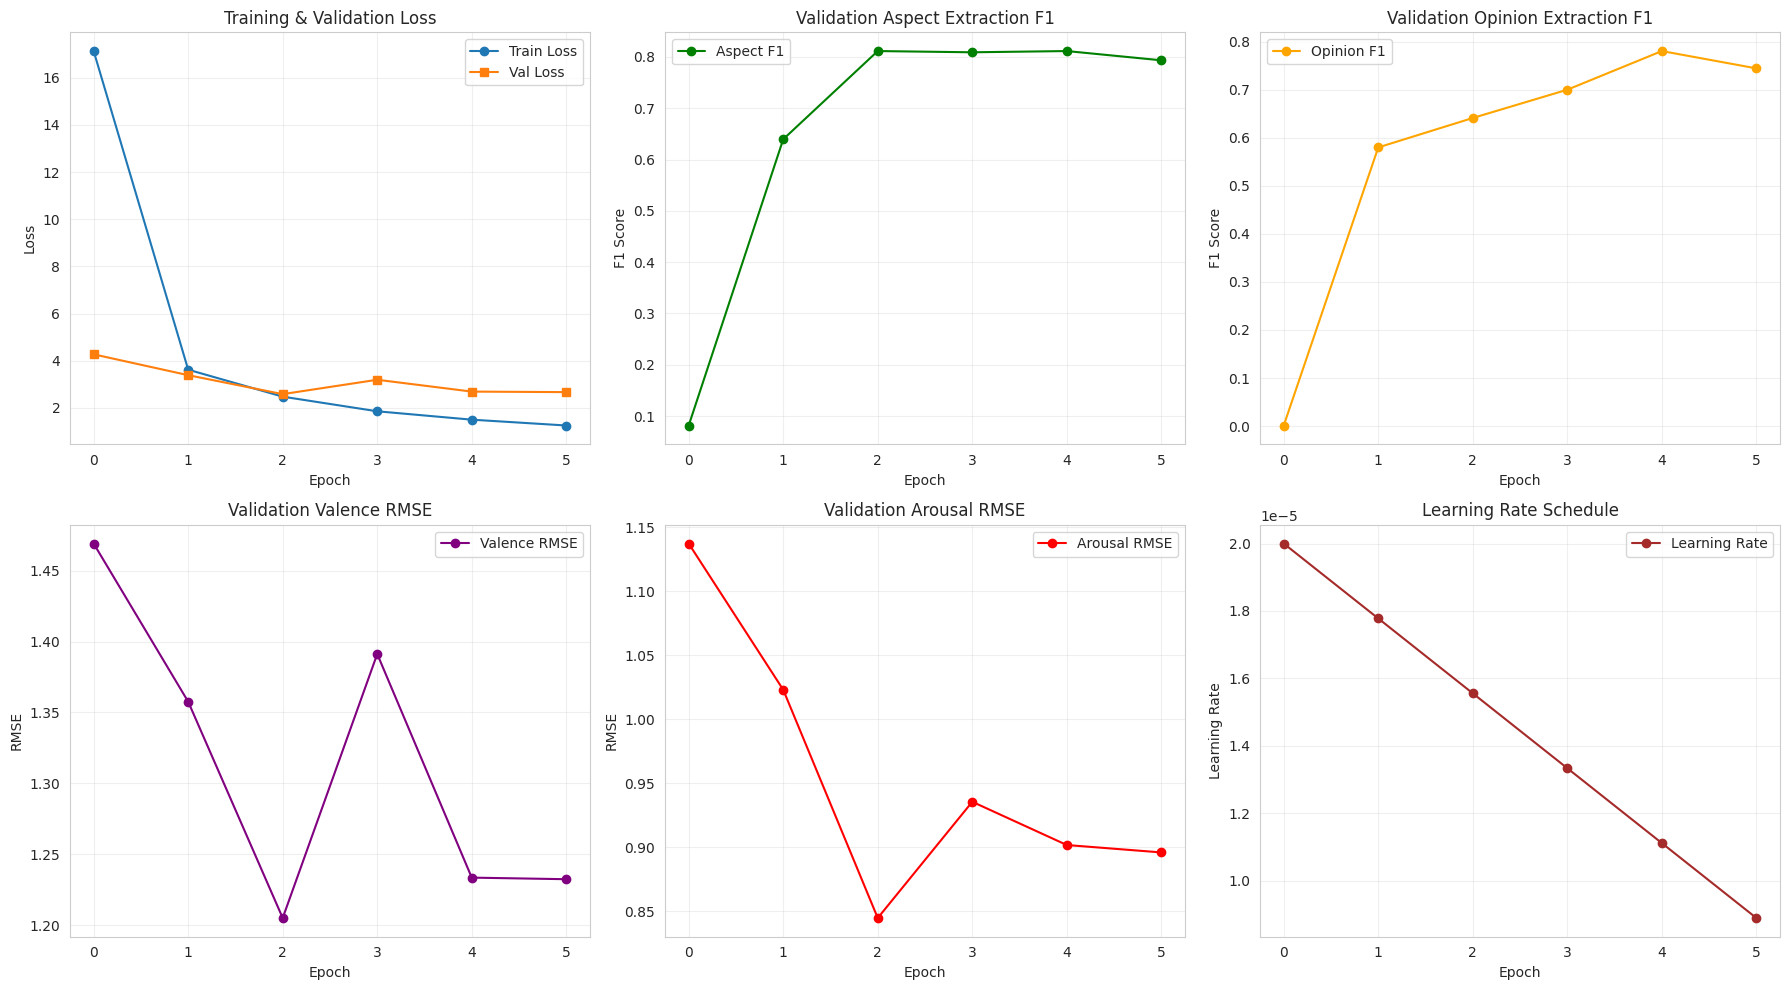


✅ Training curves saved to 'training_curves.png'


In [17]:
# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Aspect F1
axes[0, 1].plot(history['val_aspect_f1'], label='Aspect F1', marker='o', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Validation Aspect Extraction F1')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Opinion F1
axes[0, 2].plot(history['val_opinion_f1'], label='Opinion F1', marker='o', color='orange')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('F1 Score')
axes[0, 2].set_title('Validation Opinion Extraction F1')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Valence RMSE
axes[1, 0].plot(history['val_valence_rmse'], label='Valence RMSE', marker='o', color='purple')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_title('Validation Valence RMSE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Arousal RMSE
axes[1, 1].plot(history['val_arousal_rmse'], label='Arousal RMSE', marker='o', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('Validation Arousal RMSE')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Learning rate
axes[1, 2].plot(history['learning_rates'], label='Learning Rate', marker='o', color='brown')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Learning Rate')
axes[1, 2].set_title('Learning Rate Schedule')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training curves saved to 'training_curves.png'")

## 🔮 Part 18: Prediction Generation on Test Set

Load best model and generate predictions on test data.

In [56]:
import json
import pandas as pd
import torch
from torch.utils.data import DataLoader

# ==================== Load test data from JSONL ====================

data_path = "test_eng_restaurant.jsonl"

test_rows = []
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            test_rows.append(json.loads(line))

test_data = pd.DataFrame(test_rows)

print(f"📄 Loaded {len(test_data)} samples from {data_path}")

# ==================== Create test dataset ====================

test_dataset = MultiTaskDimABSADataset(
    test_data,
    tokenizer,
    config,
    is_test=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print(f"✅ Test dataset ready: {len(test_dataset)} samples, {len(test_loader)} batches")


📄 Loaded 24 samples from test_eng_restaurant.jsonl
✅ Test dataset ready: 24 samples, 3 batches


In [57]:
# Load best model
print("🔄 Loading best model checkpoint...")
checkpoint = torch.load(os.path.join(config.output_dir, 'best_model.pt'), map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Generate predictions
all_predictions = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Generating predictions")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Get predictions
        aspect_logits = outputs['aspect_logits']  # (batch, seq_len, 3)
        opinion_logits = outputs['opinion_logits']  # (batch, seq_len, 3)
        category_logits = outputs['category_logits']  # (batch, num_categories)
        valence = outputs['valence']  # (batch,)
        arousal = outputs['arousal']  # (batch,)

        # Decode BIO tags
        aspect_preds = torch.argmax(aspect_logits, dim=-1).cpu().numpy()  # (batch, seq_len)
        opinion_preds = torch.argmax(opinion_logits, dim=-1).cpu().numpy()

        # Decode categories (multi-label)
        category_probs = torch.sigmoid(category_logits).cpu().numpy()  # (batch, num_categories)
        category_preds = (category_probs > 0.5).astype(int)

        # Get VA scores
        valence_scores = valence.cpu().numpy()
        arousal_scores = arousal.cpu().numpy()

        # Store predictions
        batch_size = input_ids.size(0)
        for i in range(batch_size):
            all_predictions.append({
                'aspect_bio': aspect_preds[i],
                'opinion_bio': opinion_preds[i],
                'categories': category_preds[i],
                'valence': float(valence_scores[i]),
                'arousal': float(arousal_scores[i]),
                'tokens': tokenizer.convert_ids_to_tokens(input_ids[i].cpu().numpy())
            })

print(f"\n✅ Generated predictions for {len(all_predictions)} test samples")

🔄 Loading best model checkpoint...


Generating predictions:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Generated predictions for 24 test samples


## 🧩 Part 19: Post-Processing & Entity Extraction

Extract entities from BIO tags and reconstruct text spans.

In [58]:
def extract_entities_from_bio(bio_labels, tokens, label_map):
    """
    Extract entity spans from BIO labels.

    Args:
        bio_labels: Array of BIO label indices
        tokens: List of tokens
        label_map: Dict mapping indices to BIO labels (0=O, 1=B-*, 2=I-*)

    Returns:
        List of (start_idx, end_idx, text) tuples
    """
    entities = []
    current_entity_start = None
    current_entity_tokens = []

    for idx, label_idx in enumerate(bio_labels):
        token = tokens[idx]

        # Skip special tokens
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            if current_entity_start is not None:
                # Save current entity
                entity_text = tokenizer.convert_tokens_to_string(current_entity_tokens)
                entities.append((current_entity_start, idx - 1, entity_text.strip()))
                current_entity_start = None
                current_entity_tokens = []
            continue

        label = label_map.get(label_idx, 'O')

        if label.startswith('B-'):
            # Begin new entity
            if current_entity_start is not None:
                # Save previous entity
                entity_text = tokenizer.convert_tokens_to_string(current_entity_tokens)
                entities.append((current_entity_start, idx - 1, entity_text.strip()))

            current_entity_start = idx
            current_entity_tokens = [token]

        elif label.startswith('I-') and current_entity_start is not None:
            # Continue current entity
            current_entity_tokens.append(token)

        else:  # 'O' or mismatched I-
            if current_entity_start is not None:
                # Save current entity
                entity_text = tokenizer.convert_tokens_to_string(current_entity_tokens)
                entities.append((current_entity_start, idx - 1, entity_text.strip()))
                current_entity_start = None
                current_entity_tokens = []

    # Save last entity if any
    if current_entity_start is not None:
        entity_text = tokenizer.convert_tokens_to_string(current_entity_tokens)
        entities.append((current_entity_start, len(bio_labels) - 1, entity_text.strip()))

    return entities


def reconstruct_text_from_tokens(tokens):
    """Reconstruct original text from tokenized tokens."""
    text = tokenizer.convert_tokens_to_string([t for t in tokens if t not in ['[CLS]', '[SEP]', '[PAD]']])
    return text.strip()


# Test entity extraction
print("🧪 Testing entity extraction on first prediction:")
sample_pred = all_predictions[0]
sample_text = test_data.iloc[0]['Text']

aspect_entities = extract_entities_from_bio(
    sample_pred['aspect_bio'],
    sample_pred['tokens'],
    config.aspect_id2label
)
opinion_entities = extract_entities_from_bio(
    sample_pred['opinion_bio'],
    sample_pred['tokens'],
    config.opinion_id2label
)

print(f"Original text: {sample_text}")
print(f"Reconstructed: {reconstruct_text_from_tokens(sample_pred['tokens'])}")
print(f"\nExtracted Aspects: {aspect_entities}")
print(f"Extracted Opinions: {opinion_entities}")
print(f"Categories: {[config.category_labels[i] for i, val in enumerate(sample_pred['categories']) if val == 1]}")
print(f"Valence: {sample_pred['valence']:.2f}, Arousal: {sample_pred['arousal']:.2f}")

🧪 Testing entity extraction on first prediction:
Original text: the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !
Reconstructed: the spicy tuna roll was unusually good and the rock shrimp tempura was awesome, great appetizer to share!

Extracted Aspects: [(2, 6, 'spicy tuna roll'), (13, 18, 'rock shrimp tempura')]
Extracted Opinions: [(8, 9, 'unusually'), (10, 10, 'good'), (20, 22, 'awesome'), (24, 24, 'great')]
Categories: ['FOOD#QUALITY']
Valence: 7.53, Arousal: 7.63


## 📝 Part 20: Submission File Creation

Generate final submission JSONL file in the required format.

In [59]:
def create_submission_file(test_data, predictions, config, output_path):
    """
    Create submission JSONL file in the required format for evaluation script.

    Format expected by evaluation script:
    - For Subtask 3: Each quadruplet must be a dictionary with keys:
      {'Aspect': str, 'Opinion': str, 'Category': str, 'VA': 'valence#arousal'}
    """
    submission_entries = []

    # Convert DataFrame to list of dictionaries for easier iteration
    test_samples = test_data.to_dict('records')

    for idx, (sample, pred) in enumerate(zip(test_samples, predictions)):
        sent_id = sample['ID']
        text = sample['Text']

        # Extract aspect and opinion entities
        aspect_entities = extract_entities_from_bio(
            pred['aspect_bio'],
            pred['tokens'],
            config.aspect_id2label
        )
        opinion_entities = extract_entities_from_bio(
            pred['opinion_bio'],
            pred['tokens'],
            config.opinion_id2label
        )

        # Get predicted categories
        predicted_categories = [
            config.category_labels[i]
            for i, val in enumerate(pred['categories'])
            if val == 1
        ]

        # If no categories predicted, use a default one
        if not predicted_categories:
            predicted_categories = [config.category_labels[0]]  # Use first category as fallback

        # Match aspects with opinions (simple proximity-based matching)
        quadruplets = []

        if aspect_entities:
            for asp_start, asp_end, asp_text in aspect_entities:
                # Find closest opinion
                best_opinion = None
                min_distance = float('inf')

                for opn_start, opn_end, opn_text in opinion_entities:
                    distance = min(abs(asp_start - opn_start), abs(asp_end - opn_end))
                    if distance < min_distance:
                        min_distance = distance
                        best_opinion = (opn_start, opn_end, opn_text)

                # Use "NULL" if no opinion found
                opinion_text = best_opinion[2] if best_opinion else "NULL"

                # Create quadruplet for each category
                for category in predicted_categories:
                    if config.subtask == 3:
                        # Quadruplet format as dictionary
                        quadruplets.append({
                            'Aspect': asp_text,
                            'Opinion': opinion_text,
                            'Category': category,
                            'VA': f"{pred['valence']:.2f}#{pred['arousal']:.2f}"
                        })
                    else:
                        # Triplet format as dictionary (no Category)
                        quadruplets.append({
                            'Aspect': asp_text,
                            'Opinion': opinion_text,
                            'VA': f"{pred['valence']:.2f}#{pred['arousal']:.2f}"
                        })

        # If no aspects found, create default entry
        if not quadruplets:
            if config.subtask == 3:
                quadruplets = [{
                    'Aspect': 'NULL',
                    'Opinion': 'NULL',
                    'Category': predicted_categories[0],
                    'VA': f"{pred['valence']:.2f}#{pred['arousal']:.2f}"
                }]
            else:
                quadruplets = [{
                    'Aspect': 'NULL',
                    'Opinion': 'NULL',
                    'VA': f"{pred['valence']:.2f}#{pred['arousal']:.2f}"
                }]

        # Create submission entry with correct key names
        if config.subtask == 3:
            entry = {
                "ID": sent_id,
                "Text": text,
                "Quadruplet": quadruplets  # Singular, not plural!
            }
        else:
            entry = {
                "ID": sent_id,
                "Text": text,
                "Triplet": quadruplets  # Singular, not plural!
            }

        submission_entries.append(entry)

    # Write to JSONL file
    with open(output_path, 'w', encoding='utf-8') as f:
        for entry in submission_entries:
            f.write(json.dumps(entry, ensure_ascii=False) + '\n')

    return submission_entries


# Create submission file
output_filename = f"pred_{config.language}_{config.domain}.jsonl"
submission_data = create_submission_file(test_data, all_predictions, config, output_filename)

print(f"✅ Submission file created: {output_filename}")
print(f"📊 Total entries: {len(submission_data)}")

# Show sample submission
print("\n📄 Sample submission entry:")
print(json.dumps(submission_data[0], indent=2, ensure_ascii=False))

✅ Submission file created: pred_eng_restaurant.jsonl
📊 Total entries: 24

📄 Sample submission entry:
{
  "ID": "rest16_quad_dev_3",
  "Text": "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !",
  "Quadruplet": [
    {
      "Aspect": "spicy tuna roll",
      "Opinion": "unusually",
      "Category": "FOOD#QUALITY",
      "VA": "7.53#7.63"
    },
    {
      "Aspect": "rock shrimp tempura",
      "Opinion": "good",
      "Category": "FOOD#QUALITY",
      "VA": "7.53#7.63"
    }
  ]
}


## ✅ Part 21: Validation & Quality Checks

Validate submission format and perform quality checks.

In [61]:
# Create gold file from test data for validation
# This extracts the true labels from the test set to create a gold standard file

gold_filename = f"gold_{config.language}_{config.domain}.jsonl"

with open(gold_filename, 'w', encoding='utf-8') as f:
    for idx in range(len(test_data)):
        sample = test_data.iloc[idx]

        # Extract quadruplets from the test data
        quadruplets = []
        if config.subtask == 3:
            for quad in sample.get('Quadruplets', []):
                quadruplets.append({
                    'Aspect': quad['aspect'],
                    'Opinion': quad['opinion'],
                    'Category': quad['category'],
                    'VA': f"{quad['valence']:.2f}#{quad['arousal']:.2f}"
                })
        else:
            for trip in sample.get('Triplets', []):
                quadruplets.append({
                    'Aspect': trip['aspect'],
                    'Opinion': trip['opinion'],
                    'VA': f"{trip['valence']:.2f}#{trip['arousal']:.2f}"
                })

        entry = {
            "ID": sample['ID'],
            "Text": sample['Text'],
            "Quadruplet" if config.subtask == 3 else "Triplet": quadruplets
        }

        f.write(json.dumps(entry, ensure_ascii=False) + '\n')

print(f"✅ Gold file created: {gold_filename}")
print(f"📊 Total gold entries: {len(test_data)}")

# Show sample gold entry
with open(gold_filename, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    print("\n📄 Sample gold entry:")
    print(json.dumps(json.loads(first_line), indent=2, ensure_ascii=False))

✅ Gold file created: gold_eng_restaurant.jsonl
📊 Total gold entries: 24

📄 Sample gold entry:
{
  "ID": "rest16_quad_dev_3",
  "Text": "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !",
  "Quadruplet": []
}
